In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, ndimage
import serial
from math import *
import skimage
import random

### Create signal

Text(0.5, 1.0, 'Median filter')

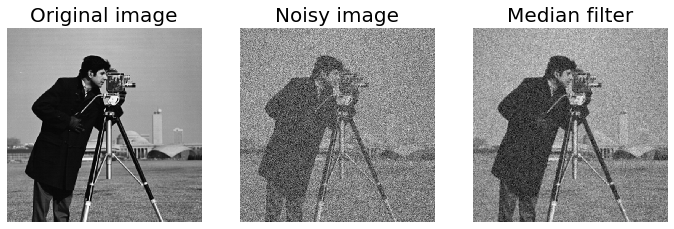

In [8]:
img = skimage.data.camera()

IMG_HEIGHT, IMG_WIDTH = img.shape

mean = 0
std = 50
num_samples = 1000
white_noise = np.random.normal(mean, std, size=img.shape) # white noise

img_noise = np.around(img + white_noise).astype(np.int32)

img_med = ndimage.median_filter(img_noise, size=3,mode='constant', cval=0)

plt.figure(figsize=(16, 5))

plt.subplot(141)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Original image', fontsize=20)
plt.subplot(142)
plt.imshow(img_noise, 'gray')
plt.axis('off')
plt.title('Noisy image', fontsize=20)
plt.subplot(143)
plt.imshow(img_med, 'gray')
plt.axis('off')
plt.title('Median filter', fontsize=20)

In [4]:
IMG_WIDTH = 10
IMG_HEIGHT = 10

random.seed(1)
img_noise = []
for i in range(IMG_HEIGHT):
    line = [random.randint(0, 255) for i in range(IMG_WIDTH)]
    img_noise.append(line)
    

img_noise = np.array(img_noise)
img_med = ndimage.median_filter(img_noise, size=3, mode='constant', cval=0)

print(img_noise)
print()
print(img_med)

zero_line = np.zeros(IMG_WIDTH).astype(np.int32)

[[ 68  32 130  60 253 230 241 194 107  48]
 [249  14 199 221   1 228 136 117  52 162]
 [ 15  11  13   4 195 110 216  14 113 224]
 [253 119 176 118 112 235 148  11 213  51]
 [ 95 151  61 170 216  97 155 145 255 201]
 [ 17 245 124 206 212  88 187 191  44 224]
 [ 55  83 201 189 250  15 240  22 157 201]
 [ 87  86 116   6 102 118 207 176 180 235]
 [137   2 196  66 105 218  28 246 186 102]
 [211 248 182 212 177   0 169 234  14 117]]

[[  0  32  32  60  60 136 136 107  52   0]
 [ 14  32  32 130 195 216 194 117 113  52]
 [ 14 119 118 118 118 148 136 117 113  52]
 [ 15  95 118 118 118 155 145 148 145 113]
 [ 95 124 151 170 170 155 148 155 191  51]
 [ 55  95 170 201 189 187 145 157 191 157]
 [ 55  87 124 189 118 187 176 180 180 157]
 [ 55  87  86 116 105 118 176 180 180 157]
 [ 86 137 116 116 105 118 176 180 180 102]
 [  0 137  66 105  66  28  28  28 102   0]]


# Testbench

### Save signal to file

In [5]:
np.concatenate([IMG_WIDTH*[0], img_noise.ravel(), IMG_HEIGHT*[0]]).astype(np.int32).tofile('./median_tb_input.bin')

### Get TB output from file

In [7]:
median_tb_out = np.fromfile('./median_tb_output.bin', dtype=np.int32)
me = median_tb_out.reshape(IMG_WIDTH, IMG_HEIGHT)

print(me)

[[  0  32  32  60  60 136 136 107  52   0]
 [ 14  32  32 130 195 216 194 117 113  52]
 [ 14 119 118 118 118 148 136 117 113  52]
 [ 15  95 118 118 118 155 145 148 145 113]
 [ 95 124 151 170 170 155 148 155 191  51]
 [ 55  95 170 201 189 187 145 157 191 157]
 [ 55  87 124 189 118 187 176 180 180 157]
 [ 55  87  86 116 105 118 176 180 180 157]
 [ 86 137 116 116 105 118 176 180 180 102]
 [  0 137  66 105  66  28  28  28 102   0]]


# FPGA

### Serial communication

In [9]:
#IMG_WIDTH, IMG_HEIGHT = img.shape

INPUT_WIDTH = 32 # input width
OUTPUT_WIDTH = 32 # output width
HEX_LEN = INPUT_WIDTH // 4 if INPUT_WIDTH % 4 == 0 else INPUT_WIDTH // 4 + 1 # hex number length

n_bytes = int(HEX_LEN / 2)

samples = np.concatenate((IMG_WIDTH*[0], img_noise.ravel(), IMG_WIDTH*[0]))
samples = [(i.item()).to_bytes(n_bytes, byteorder='big', signed=True) for i in samples]

In [10]:
fpga_bytes_out = b''
fpga_out = list()

tx_cnt = 0
rx_cnt = 0
line_cnt = 0

with serial.Serial('/dev/ttyUSB0', 115200, timeout = 1) as ser:
    for i in samples:
        tx_cnt += 1
        
        if tx_cnt == IMG_WIDTH:
            tx_cnt = 0
            line_cnt +=1
            #print(f"line: {line_cnt}")
        
        #print("write")
        ser.write(i)
        
        if tx_cnt == 0:
            for i in range(IMG_WIDTH):
                for j in range(4):
                    #print(f"read {j+1}")
                    s = ser.read()
                    
                    if line_cnt > 2:
                        fpga_bytes_out = fpga_bytes_out + s
         
                if line_cnt > 2:
                    fpga_out.append(int.from_bytes(fpga_bytes_out, byteorder='big', signed=True))
                    fpga_bytes_out = b''

print("done!")
print((img_med == np.array(fpga_out).reshape(IMG_HEIGHT,IMG_WIDTH)).all())

done!
True


Text(0.5, 1.0, 'Median (FPGA)')

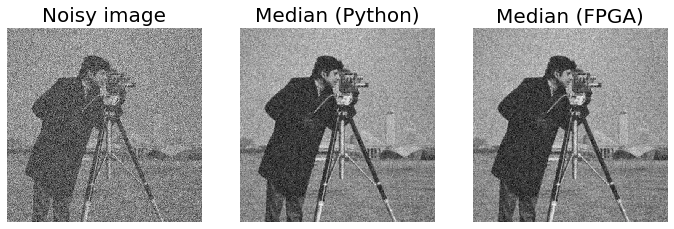

In [11]:
plt.figure(figsize=(16, 5))

plt.subplot(141)
plt.imshow(img_noise, 'gray')
plt.axis('off')
plt.title('Noisy image', fontsize=20)
plt.subplot(142)
plt.imshow(img_med, 'gray')
plt.axis('off')
plt.title('Median (Python)', fontsize=20)
plt.subplot(143)
plt.imshow(np.array(fpga_out).reshape(IMG_HEIGHT,IMG_WIDTH), 'gray')
plt.axis('off')
plt.title('Median (FPGA)', fontsize=20)